<a href="https://colab.research.google.com/github/Idan-Alter/OU-22961-Deep-Learning/blob/main/22961_7_2_MNIST_autoencoder_and_denoising_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
train_data_transformed = torchvision.datasets.FashionMNIST(
    root="/22961", train=True, download=True,
    transform=torchvision.transforms.ToTensor())
train_dataloader = DataLoader(
    train_data_transformed, batch_size=1024)

img, _ = next(iter(train_dataloader))

test_data_transformed = torchvision.datasets.FashionMNIST(
    root="/22961", train=False, download=True,
    transform=torchvision.transforms.ToTensor())
test_dataloader = DataLoader(
    test_data_transformed, batch_size=1024)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/train-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /22961/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /22961/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /22961/FashionMNIST/raw



In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cpu


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear = nn.Linear(784,latent_dim)
        self.relu   = nn.ReLU()
    def forward(self, image):
      flattned         = image.flatten(start_dim=1)
      compressed_image = self.relu(self.linear(flattned))
      return compressed_image

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.linear    = nn.Linear(latent_dim, 784)
        self.sigmoid   = nn.Sigmoid()
    def forward(self, compressed_image):
      decoded             = self.linear(compressed_image)
      decoded             = self.sigmoid(decoded)
      reconstructed_image = decoded.reshape(-1,1,28,28)
      return reconstructed_image

In [ ]:
latent_dim  = 10
autoencoder = nn.Sequential(Encoder(latent_dim),
                            Decoder(latent_dim)).to(device)
optimizer   = torch.optim.AdamW(autoencoder.parameters())
MSELoss=nn.MSELoss()

In [ ]:
def iterate_batch(imgs):
  imgs = imgs.to(device)
  optimizer.zero_grad()
  reconstructed = autoencoder(imgs)
  loss = MSELoss(reconstructed, imgs)
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
batches=len(train_dataloader)
epochs = 20
batch_loss = torch.empty(batches, device=device)
epoch_loss =torch.empty(epochs, device=device)
for epoch_idx in tqdm(range(epochs)):
  for batch_idx, (imgs, _) in enumerate(train_dataloader):
    batch_loss[batch_idx] = iterate_batch(imgs)
  with torch.no_grad():
    epoch_loss[epoch_idx] = batch_loss.mean()

100%|██████████| 20/20 [01:59<00:00,  5.99s/it]


In [ ]:
epoch_loss[epoch_idx]

tensor(0.0361)

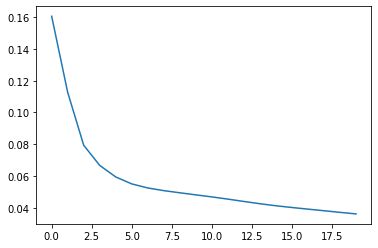

In [ ]:
plt.plot(epoch_loss[:epoch_idx+1].cpu().detach());

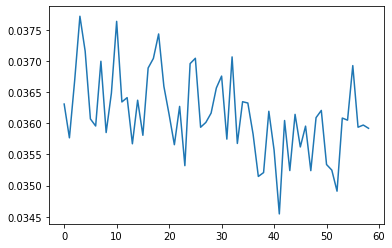

In [ ]:
plt.plot(batch_loss.cpu().detach());

In [ ]:
imgs, labels = next(iter(test_dataloader))

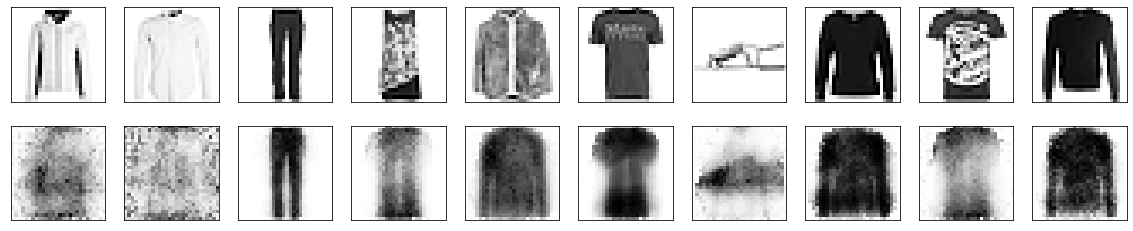

In [ ]:
num_images = 10
with torch.no_grad():
  reconstructed = autoencoder(imgs.to(device)).cpu()
  fig,axes = plt.subplots(2, num_images, sharey=True)
  fig.set_figheight(4)
  fig.set_figwidth(20)
  rand_idx = torch.randint(size=(num_images,), high=imgs.size(0))
  for idx in range(num_images):
    axes[0,idx].imshow(imgs[rand_idx[idx],...].reshape(28,28).detach(), cmap='Greys')
    axes[0,idx].axes.get_xaxis().set_visible(False)
    axes[0,idx].axes.get_yaxis().set_visible(False)


    axes[1,idx].imshow(reconstructed[[rand_idx[idx]],...].reshape(28,28).detach(), cmap='Greys')
    axes[1,idx].axes.get_xaxis().set_visible(False)
    axes[1,idx].axes.get_yaxis().set_visible(False)


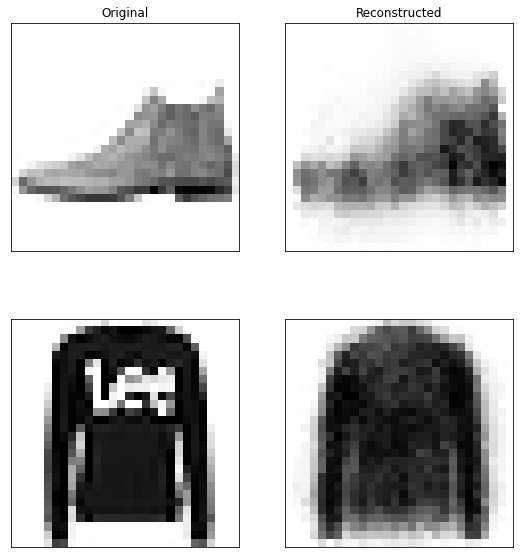

In [ ]:
num_images=2
with torch.no_grad():
  reconstructed = autoencoder(imgs.to(device)).cpu()
  fig,axes = plt.subplots(num_images,2)
  fig.set_figheight(10)
  fig.set_figwidth(9)
  for idx in range(num_images):
    axes[idx,0].imshow(imgs[idx,...].reshape(28,28).detach(), cmap='Greys')
    axes[idx,0].axes.get_xaxis().set_visible(False)
    axes[idx,0].axes.get_yaxis().set_visible(False)
    

    axes[idx,1].imshow(reconstructed[idx,...].reshape(28,28).detach(), cmap='Greys')
    axes[idx,1].axes.get_xaxis().set_visible(False)
    axes[idx,1].axes.get_yaxis().set_visible(False)
axes[0,0].set_title("Original");
axes[0,1].set_title("Reconstructed");

#Denoising AE

In [ ]:
latent_dim = int(784 * 1.2)
DAE        = nn.Sequential(Encoder(latent_dim),
                           Decoder(latent_dim)).to(device)
optimizer  = torch.optim.AdamW(DAE.parameters())
MSELoss    = nn.MSELoss()
corruptor  = nn.Dropout()

In [ ]:
def iterate_batch_DAE(original_imgs, corrupted_imgs):
  original_imgs  = original_imgs.to(device)
  corrupted_imgs = corrupted_imgs.to(device)
  optimizer.zero_grad()
  reconstructed = DAE(corrupted_imgs)
  loss          = MSELoss(reconstructed, original_imgs)
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
batches = len(train_dataloader)
epochs  = 20
batch_loss = torch.empty(batches,device=device)
epoch_loss = torch.empty(epochs,device=device)
for epoch_idx in tqdm(range(epochs)):
  for batch_idx, (imgs, _) in enumerate(train_dataloader):
    corrupted_imgs = corruptor(imgs)
    batch_loss[batch_idx] = iterate_batch_DAE(imgs, corrupted_imgs)
  with torch.no_grad():
    epoch_loss[epoch_idx] = batch_loss.mean()

100%|██████████| 20/20 [04:26<00:00, 13.34s/it]


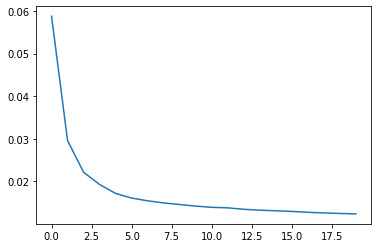

In [ ]:
plt.plot(epoch_loss[:epoch_idx+1].cpu().detach());

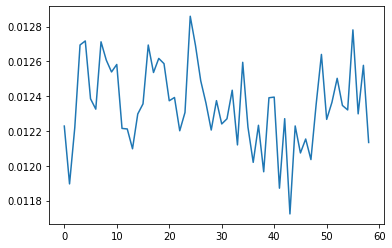

In [ ]:
plt.plot(batch_loss.cpu().detach());

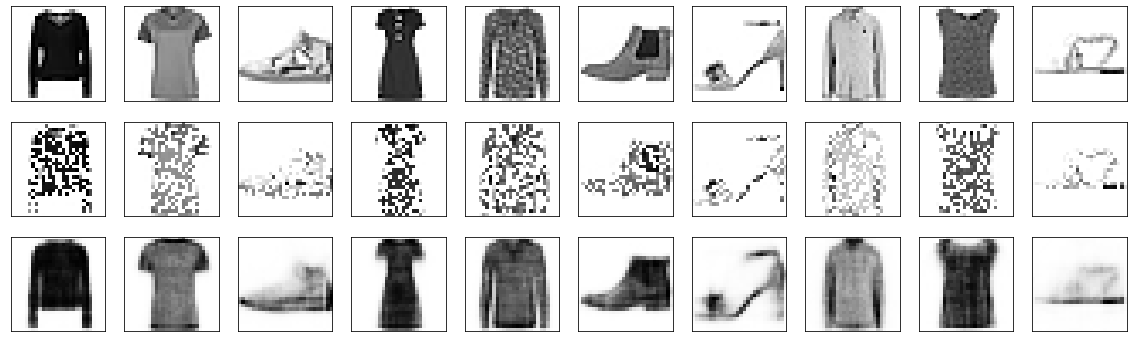

In [ ]:
num_images = 10
with torch.no_grad():
  corrupted_imgs = corruptor(imgs)
  reconstructed  = DAE(corrupted_imgs.to(device)).cpu()
fig,axes = plt.subplots(3, num_images, sharey=True)
fig.set_figheight(6)
fig.set_figwidth(20)
rand_idx = torch.randint(size=(num_images,), high=imgs.size(0))
for idx in range(num_images):
  axes[0,idx].imshow(imgs[rand_idx[idx],...].reshape(28,28).detach(), cmap='Greys')
  axes[0,idx].axes.get_xaxis().set_visible(False)
  axes[0,idx].axes.get_yaxis().set_visible(False)

  axes[1,idx].imshow(corrupted_imgs[rand_idx[idx],...].reshape(28,28).detach(), cmap='Greys')
  axes[1,idx].axes.get_xaxis().set_visible(False)
  axes[1,idx].axes.get_yaxis().set_visible(False)

  axes[2,idx].imshow(reconstructed[[rand_idx[idx]],...].reshape(28,28).detach(), cmap='Greys')
  axes[2,idx].axes.get_xaxis().set_visible(False)
  axes[2,idx].axes.get_yaxis().set_visible(False)


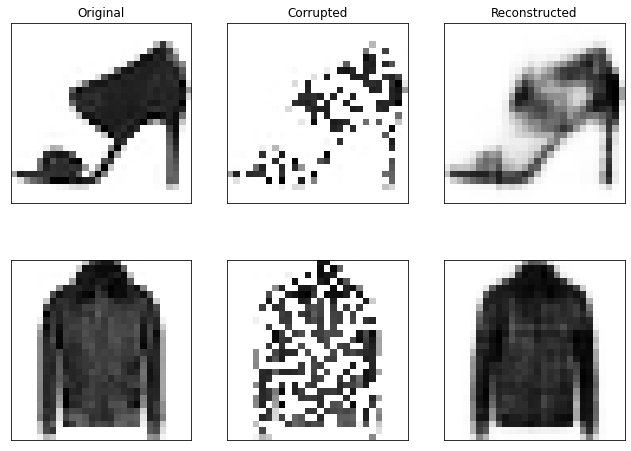

In [ ]:
num_images = 2
with torch.no_grad():
  corrupted_imgs = corruptor(imgs)
  reconstructed  = DAE(corrupted_imgs.to(device)).cpu()
fig,axes = plt.subplots(num_images,3)
fig.set_figheight(8)
fig.set_figwidth(11)
for idx in range(num_images):
  axes[idx,0].imshow(imgs[idx,...].reshape(28,28).detach(), cmap='Greys')
  axes[idx,0].axes.get_xaxis().set_visible(False)
  axes[idx,0].axes.get_yaxis().set_visible(False)
  
  axes[idx,1].imshow(corrupted_imgs[idx,...].reshape(28,28).detach(), cmap='Greys')
  axes[idx,1].axes.get_xaxis().set_visible(False)
  axes[idx,1].axes.get_yaxis().set_visible(False)

  axes[idx,2].imshow(reconstructed[idx,...].reshape(28,28).detach(), cmap='Greys')
  axes[idx,2].axes.get_xaxis().set_visible(False)
  axes[idx,2].axes.get_yaxis().set_visible(False)
    
axes[0,0].set_title("Original");
axes[0,1].set_title("Corrupted");
axes[0,2].set_title("Reconstructed");

#Generating New Samples

In [ ]:
print(list(DAE.named_children()))
encoder = DAE[0]
decoder = DAE[1]

[('0', Encoder(
  (linear): Linear(in_features=784, out_features=940, bias=True)
  (relu): ReLU()
)), ('1', Decoder(
  (linear): Linear(in_features=940, out_features=784, bias=True)
  (sigmoid): Sigmoid()
))]


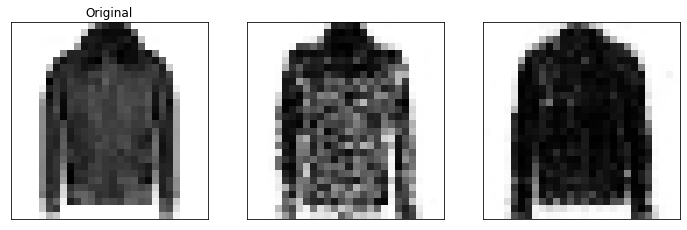

In [ ]:
num_samples = 2
with torch.no_grad():
  one_img = imgs[1,...].to(device)
  encoded = encoder(one_img)
  encoded.size()
  perturbation     = torch.randn((num_samples, *encoded.size()))
  perturbed_latent = encoded*(1+perturbation)
  new_samples      = decoder(perturbed_latent)

fig,axes = plt.subplots(1, num_samples+1)
fig.set_figheight(8)
fig.set_figwidth(num_samples*6)
for idx in range(num_samples):
  axes[idx+1].imshow(new_samples[idx,...].cpu().reshape(28,28).detach(), cmap='Greys')
  axes[idx+1].axes.get_xaxis().set_visible(False)
  axes[idx+1].axes.get_yaxis().set_visible(False)
  
axes[0].imshow(one_img[0,...].cpu().reshape(28,28).detach(), cmap='Greys')
axes[0].set_title("Original");
axes[0].axes.get_xaxis().set_visible(False)
axes[0].axes.get_yaxis().set_visible(False)